In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

import Project_library as pl

## Auto Regressive model for data demand change

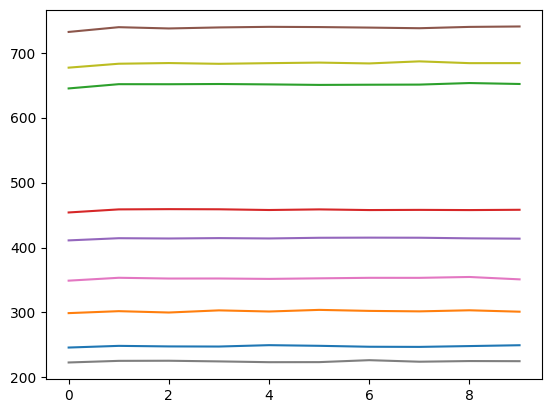

In [3]:
def ar1_process(demand_over_time: jnp.ndarray, variability : float, time_slots : int, ar_weight : float, key : jnp.ndarray) -> jnp.ndarray:
    white_noise = jrandom.normal(key, demand_over_time.shape)  # Generate white noise

     # Add the initial demand to the white noise

    for i in range(1, time_slots):
        demand_over_time = demand_over_time.at[i].set(ar_weight * demand_over_time[i-1] + white_noise[i]+ demand_over_time[0])

    return demand_over_time


# Demanded bit rate changes with time
# Demand is intialised
for k in range(1, 10):
    demand = jnp.array([jrandom.randint(jrandom.PRNGKey(k), (1), minval=200, maxval = 750)])
    
    # The reconfiguration period is 30 seconds
    reconfiguration_period = 30
    # The number of reconfigurations is 10
    time_slots = 10

    time_slot_duration =int( reconfiguration_period / time_slots)

    # Setup array with demand over time
    demand_over_time = jnp.zeros((time_slots, demand.shape[0]))

    demand_over_time = demand_over_time.at[0].set(demand[0].item())

    #print(demand_over_time)

    key, subkey = jrandom.split(jrandom.PRNGKey(k))
    # Calculate the AR(1) process for the demand

    demand_over_time = ar1_process(demand_over_time, 1, time_slots, 0.01, subkey)

    plt.plot(demand_over_time)

## Markov Distribution

In [4]:
def markov_step(state, key, A):
    key, subkey = jrandom.split(key)
    probs = A[state]  # Transition probabilities from current state
    next_state = jrandom.choice(subkey, A.shape[0], p=probs)
    return next_state, next_state

# Function for state change given A
def user_state_change(state_change_matrix : jnp.ndarray, state : int, time_series : jnp.ndarray, key : jnp.ndarray) -> jnp.ndarray:
    # Create a copy of the state change matrix

    key = jrandom.split(key, time_series.shape[0]-1)

    def scan_fn(state,key):
        return markov_step(state, key, state_change_matrix)

    _, states = jax.lax.scan(scan_fn, state, key)

    return jnp.concatenate([jnp.array([state]), states])

seed = 42

key = jrandom.PRNGKey(seed)

time_series = jnp.zeros((time_slots, 1))
# Create a state change matrix

state_change_matrix = jnp.array([[0.1, 0.9], 
                                 [0.3, 0.7]])

# Intial state is 0
state = 0
time_series = user_state_change(state_change_matrix, state, time_series, key)

time_series, time_series.shape[0]

(Array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32), 10)

In [5]:
seed = 10

key = jrandom.PRNGKey(seed)
# Number of users in a cell
num_users = jrandom.choice(key, jnp.arange(10,20))

user_rate = 100e3 # 100 kbps

time_series = jnp.zeros((time_slots, 1))

series = []

# Loop over the number of users, can compute the demand based on the state change of the users.
for i in range(num_users):
    key, subkey = jrandom.split(key)
    # Create a state change matrix
    state_change_matrix = jnp.array([[0.3, 0.7], 
                                     [0.3, 0.7]])
    # Intial state is 1
    state = 1
    series.append(user_state_change(state_change_matrix, state, time_series, key))

series

[Array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0], dtype=int32),
 Array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32),
 Array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0], dtype=int32),
 Array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32),
 Array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1], dtype=int32),
 Array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0], dtype=int32),
 Array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)]

Text(0.5, 1.0, 'Demand Over Time')

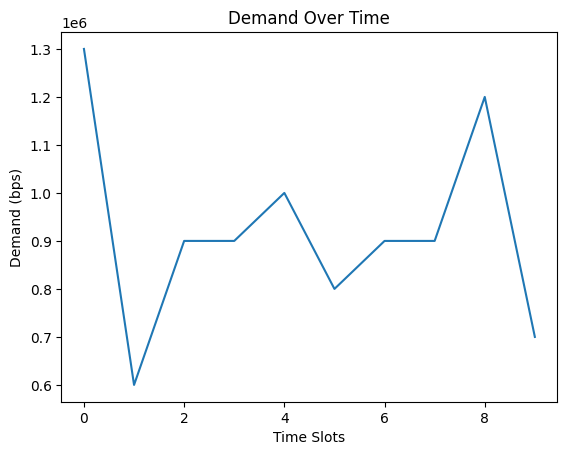

In [6]:
# Sum along the columns to get the total demand
total_demand = jnp.sum(jnp.array(series), axis=0)
total_demand = total_demand.flatten()*100e3

total_demand
# Plot the demand over time
plt.plot(total_demand, label='Total Demand')
plt.xlabel('Time Slots')
plt.ylabel('Demand (bps)')
plt.title('Demand Over Time')

In [40]:
earth_radius = 6371  # in kilometers

satellite_height = 600  # in meters

# Place a satellite at the
satellite_position = jnp.array([ satellite_height + earth_radius ,0, 0])  # in kilometers

# Calculate the viewing angle
lat_range, lon_range, _, _,_, angle_of_interest = pl.visible_angle(jnp.deg2rad(30), satellite_position)

lon_range = jnp.array(lon_range)
lon_range = lon_range.at[1].set(lon_range[1]+(lon_range[1]-lon_range[0]))

# Define the grid size and resolution, with 50 km size at the equator
grid_size = 50  # in kilometers
# Leading to an angle of 
angle_of_cell_size = grid_size/earth_radius

# Calculate the number of cells in the grid
num_cells_lat = int((lat_range[1] - lat_range[0]) / angle_of_cell_size)
num_cells_lon = int((lon_range[1] - lon_range[0]) / angle_of_cell_size)

# Create a grid of cells
mesh_grid = pl.generate_latitude_longitude_points(num_cells_lat, num_cells_lon, lat_range, lon_range)

# Recover list of lat and lon points
lat_points, long_points = mesh_grid[0][:,0], mesh_grid[1][0,:]

print(jnp.rad2deg(angle_of_interest))

print(lat_points)
print(long_points)

7.6754184
[-0.13002127 -0.1221412  -0.11426113 -0.10638105 -0.09850097 -0.09062089
 -0.08274081 -0.07486074 -0.06698066 -0.05910058 -0.05122051 -0.04334043
 -0.03546035 -0.02758027 -0.01970019 -0.01182012 -0.00394004  0.00394004
  0.01182012  0.0197002   0.02758027  0.03546035  0.04334043  0.05122051
  0.05910059  0.06698066  0.07486074  0.08274081  0.0906209   0.09850097
  0.10638105  0.11426112  0.12214121  0.13002127]
[-0.13002127 -0.1221412  -0.11426113 -0.10638105 -0.09850097 -0.09062089
 -0.08274082 -0.07486074 -0.06698066 -0.05910058 -0.0512205  -0.04334043
 -0.03546035 -0.02758027 -0.0197002  -0.01182012 -0.00394004  0.00394004
  0.01182011  0.0197002   0.02758027  0.03546035  0.04334042  0.0512205
  0.05910057  0.06698066  0.07486074  0.08274081  0.0906209   0.09850097
  0.10638104  0.11426111  0.1221412   0.13002127  0.13790135  0.14578143
  0.1536615   0.16154158  0.16942166  0.17730175  0.18518183  0.19306189
  0.20094196  0.20882206  0.21670215  0.2245822   0.23246229  0.2

In [41]:
visible_area_of_sat_one = pl.calculate_if_cells_within_visible_area(jnp.rad2deg(lat_points),jnp.rad2deg(long_points), 0, 0, 6000, jnp.rad2deg(angle_of_interest))

print(visible_area_of_sat_one)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


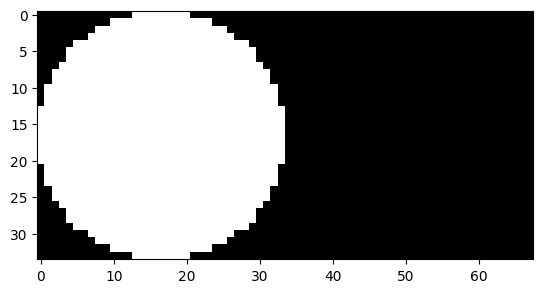

In [106]:
import matplotlib.pyplot as plt
plt.imshow(visible_area_of_sat_one, cmap='gray')



In [43]:
visible_area_of_sat_two = pl.calculate_if_cells_within_visible_area(jnp.rad2deg(lat_points),jnp.rad2deg(long_points), 0, 7.6, 6000, jnp.rad2deg(angle_of_interest))

print(visible_area_of_sat_two)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


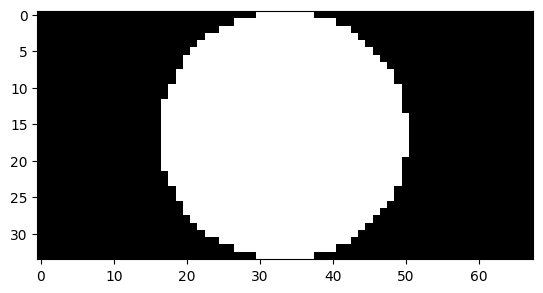

In [44]:
plt.imshow(visible_area_of_sat_two, cmap='gray')

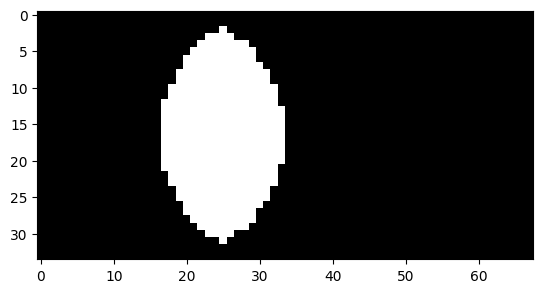

In [45]:
# The intersection between the two visible areas
intersection = jnp.logical_and(visible_area_of_sat_one, visible_area_of_sat_two)
plt.imshow(intersection, cmap='gray')

### Distribute the users across cells according to a random process, optimise the allocation.
### Check what happens over time

In [46]:
mesh_grid_comb = jnp.stack(mesh_grid, axis=-1)
mesh_grid_comb.shape

seed = 10

key = jrandom.PRNGKey(seed)

base_user_demand = 100e3

# Set a high vs low density for the cells

cells = []


for i in range(mesh_grid_comb.shape[0]):
    cells_row = []
    for j in range(mesh_grid_comb.shape[1]):
        
        density = jrandom.choice(key, jnp.array([3, 8]))

        key, subkey = jrandom.split(key)
        user_list = []
        #print([pl.User(mesh_grid_comb[i,j,0], mesh_grid_comb[i,j,1], x, jrandom.choice(key, jnp.array([0,1]), p=jnp.array([0.1,0.9]))) for x in range(density)])
        for x in range(density):
            key, subkey = jrandom.split(key)
            #print(jrandom.choice(key, jnp.array([0,1]), p=jnp.array([0.1,0.9])))
            user_list.append(pl.User(mesh_grid_comb[i,j,0], mesh_grid_comb[i,j,1], x, jrandom.choice(key, jnp.array([0,1])*base_user_demand, p=jnp.array([0.1,0.9]))))
        
        cells_row.append(pl.square_cell(
            lat = mesh_grid_comb[i,j,0], 
            longi = mesh_grid_comb[i,j,1],
            lat_width=[],
            longi_width=[],
            density=density,
            id=i*mesh_grid_comb.shape[1]+j,
            users= user_list,
            users_amount=density
        ))

        key, subkey = jrandom.split(key)
    cells.append(cells_row)

In [47]:
print(len(cells[0]))
print(len(cells))

68
34


### Lets try to run the optimisation on the single satellite, and the cells it can see.

In [48]:
import pulp

def calculate_demand_of_cell(cell : pl.square_cell) -> float:
    # Calculate the demand of the cell based on the users in it
    demand = 0
    for user in cell.users:
        demand += user.demand

    return demand

calculate_demand_of_cell(cells[0][0])

Array(500000., dtype=float32, weak_type=True)

In [49]:
demand_list = []

for i in range(len(cells)):
   
    for j in range(len(cells[i])):
        if visible_area_of_sat_one[i,j]:
            demand = calculate_demand_of_cell(cells[i][j])
            demand_list.append(demand) 


demand = jnp.array(demand_list)
demand

Array([500000., 700000., 500000., 200000., 800000., 600000., 300000.,
       200000., 600000., 300000., 200000., 800000., 200000., 200000.,
       300000., 300000., 700000., 800000., 300000., 800000., 200000.,
       300000., 700000., 200000., 800000., 300000., 300000., 300000.,
       700000., 200000., 200000., 200000., 700000., 200000., 300000.,
       800000., 600000., 800000., 300000., 300000., 300000., 300000.,
       300000., 300000., 800000., 200000., 800000., 300000., 700000.,
       300000., 300000., 800000., 600000., 700000., 300000., 700000.,
       300000., 800000., 300000., 300000., 800000., 300000., 200000.,
       800000., 300000., 800000., 300000., 700000., 300000., 200000.,
       300000., 300000., 700000., 500000., 700000., 800000., 800000.,
       800000., 800000., 200000., 800000., 300000., 200000., 300000.,
       700000., 800000., 300000., 800000., 200000., 300000., 300000.,
       800000., 300000., 600000., 700000., 300000., 300000., 800000.,
       700000., 3000

[6971    0    0]


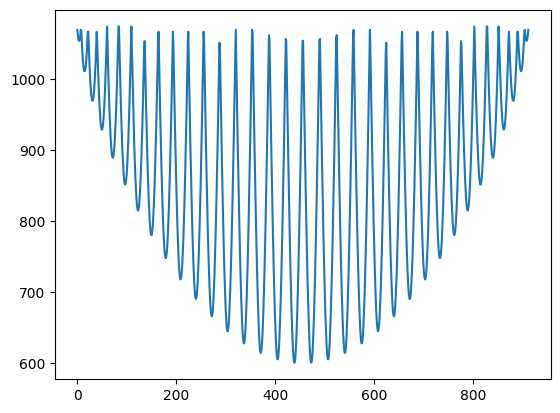

In [50]:
# calculate the distance from the first satellite to the cells

distance = []

for x in range(len(cells)):
    for y in range(len(cells[x])):
        if visible_area_of_sat_one[x,y]:
            position = pl.spherical_to_cartesian(earth_radius, cells[x][y].lat, cells[x][y].longi)
            distance.append(pl.calculate_distance(position[0], position[1],position[2], satellite_position))

print(satellite_position)

distance = jnp.array(distance)
distance
plt.plot(distance)

In [89]:
# Satellite paramterse
satellite_height = 600  # in km
number_of_beams_per_satellite = 19
satellite_bandwidth = 30e6 # in Hz n256
satellite_bandwidth_per_beam = satellite_bandwidth # in Hz
sky_temperature = 290 # in K
satellite_gain = 30 # in dBi
satellite_central_frequency = 2 # in GHz
satellite_power_per_beam = 75.4 # in W

# Full frequency reuse

snr = jax.vmap(pl.calculate_snr, in_axes=(None,None,None,0,None))(satellite_power_per_beam, satellite_gain, satellite_bandwidth, distance, 0)

rates = jax.vmap(pl.calculate_capacity, in_axes=(0,None))(snr, satellite_bandwidth)

rates

Array([12525722., 12683784., 12791406., 12845898., 12845898., 12791406.,
       12683784., 12525722., 12582004., 12905338., 13187936., 13423165.,
       13605218., 13729366., 13792317., 13792317., 13729366., 13605218.,
       13423165., 13187936., 12905338., 12582004., 12584765., 13020142.,
       13426854., 13796470., 14120585., 14391133., 14601122., 14744534.,
       14817298., 14817298., 14744534., 14601122., 14391133., 14120585.,
       13796470., 13426854., 13020142., 12584765., 12855276., 13369570.,
       13862931., 14325872., 14748311., 15120069., 15431461., 15673639.,
       15839435., 15923649., 15923649., 15839435., 15673639., 15431461.,
       15120069., 14748311., 14325872., 13862931., 13369570., 12855276.,
       12431224., 13023299., 13613262., 14192450., 14750768., 15277140.,
       15759487., 16185721., 16543923., 16823314., 17014908., 17112412.,
       17112412., 17014908., 16823314., 16543923., 16185721., 15759487.,
       15277140., 14750768., 14192450., 13613262., 

In [107]:
# Setup the optimization window
import numpy as np


window = 30
time_step = 0.25

R = np.array(rates)
D = np.array(demand)

T = int(window/time_step)
I = np.arange(T)
B = number_of_beams_per_satellite
cell_visible_ids = np.arange(len(distance))

problem = pulp.LpProblem("Satellite_optimization", pulp.LpMaximize)

t = pulp.LpVariable("t", lowBound=0, cat='Continuous')
x = pulp.LpVariable.dicts("x", (I, cell_visible_ids), cat='Binary')

# Objective
problem += t 

# Constraints
for k in cell_visible_ids:
    problem += t <= (R / (T * D[k])) * pulp.lpSum(x[i][k] for i in I)

for i in I:
    problem += B >= pulp.lpSum(x[i][k] for k in cell_visible_ids) 


problem.solve(pulp.PULP_CBC_CMD(msg=1, maxNodes= 1000))


1

In [99]:
# Results
print("Status:", pulp.LpStatus[problem.status])
print("Optimal t:", pulp.value(t))
print("Selected (i, k) pairs where x[i][k] = 1:")

Status: Optimal
Optimal t: 0.0
Selected (i, k) pairs where x[i][k] = 1:


In [100]:
schedule = np.zeros((T, cell_visible_ids.shape[0]))
for i in I:
    for k in cell_visible_ids:
        if pulp.value(x[i][k]) == 1:
            schedule[i][k] = 1

Text(0.5, 1.0, 'Beam Allocation Schedule')

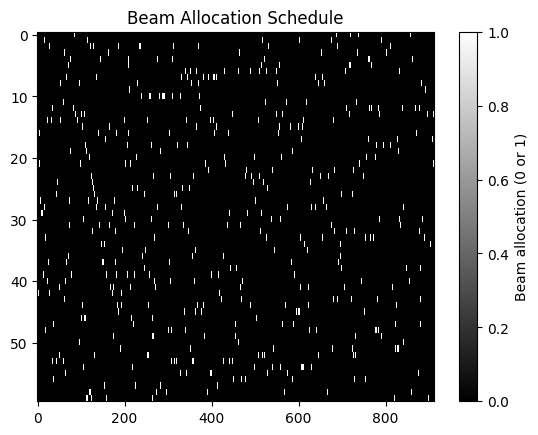

In [101]:
plt.imshow(schedule, cmap='gray', aspect='auto', interpolation='none')
plt.colorbar(label='Beam allocation (0 or 1)')
plt.title("Beam Allocation Schedule")

In [102]:
# Calculate the C/D for each area
C_D = np.zeros(len(demand))
for i in range(len(demand)):
    C_D[i] = rates[i] * np.sum(schedule[:, i]) / (demand[i]*T)
print("C/D for each area:", C_D)
print("C/D mean:", np.mean(C_D))

C/D for each area: [0.41752407 0.60398972 0.42638019 1.07049155 0.53524578 0.7106337
 0.70465469 1.04381013 0.34950012 0.         1.09899461 0.27964926
 1.1337682  1.14411378 0.76623982 0.76623982 0.65377933 0.5668841
 0.74573141 0.54949731 1.07544482 0.         0.59927452 1.08501184
 0.55945224 0.76647055 0.78447694 0.         0.69529152 1.22871113
 1.23477483 0.         0.70212066 1.21676016 0.79950738 0.58835769
 0.76647055 0.55945224 0.         0.         0.         0.74275386
 0.         0.79588175 0.61451298 1.26000571 0.64297754 0.8707577
 0.75425881 0.         0.88464719 0.65997648 0.43537885 0.73483145
 0.         0.70230055 0.         0.57762212 0.         0.71418202
 0.51796764 0.         1.13443851 0.59135211 0.         0.63654751
 0.         0.77074862 0.         1.40194285 0.         0.95068955
 0.81487674 0.56716359 0.80111021 0.6893301  0.67440504 0.6566453
 0.63654751 1.22923064 0.59135211 0.         1.08527493 0.69062358
 0.59196305 0.54501283 0.76325256 0.2999559  1.

In [104]:
np.mean(rates)

Array(18967318., dtype=float32)

In [97]:
schedule.shape

(30, 912)